# Ensembling


In [15]:
import torch
import torchvision
from torchvision.transforms import v2

import torchinfo

import matplotlib.pyplot as plt
import numpy as np
import time

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, '../../util')
import vcpi_util

In [16]:
def train_III(model, train_loader, val_loader, epochs, loss_fn, optimizer, scheduler, early_stopper, save_prefix = 'model'):

    history = {}
    history['accuracy'] = []
    history['val_acc'] = []
    history['val_loss'] = []
    history['loss'] = []
    best_val_loss = np.inf

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader, 0):
            
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            loss = loss_fn(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        model.eval()
        v_correct = 0
        val_loss = 0.0
        with torch_no_grad():
            for i,t in val_loader:
                i = i.to(device)
                t = t.to(device)
                o = model(i)
                _,p = torch.max(o,1)
                
                #with torch.no_grad():
                val_loss += loss_fn(o, t)

                v_correct += (p == t).sum()

        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if old_lr != new_lr:
            print('==> Learning rate updated: ', old_lr, ' -> ', new_lr)

        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / len(train_loader.dataset)
        v_accuracy = 100 * v_correct / len(val_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.6f}; Accuracy: {accuracy:0.4f}; Val Loss: {val_loss:0.6f}; Val Acc: {v_accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['val_acc'].append(v_accuracy.cpu().numpy())
        history['val_loss'].append(val_loss.cpu().detach().numpy())
        history['loss'].append(epoch_loss.cpu().detach().numpy())
 
        ###### Saving ######
        if val_loss < best_val_loss:
           
            torch.save({
                'epoch': epoch,
                'model':model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
                },
                f'{save_prefix}_best.pt')

        if early_stopper(val_loss):
            print('Early stopping!')
            break
        
    print('Finished Training')

    return(history)


def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    for i, (images, targets) in enumerate(data_loader):
         
        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum 
        # value of each row of the input tensor in the given dimension dim; 
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number        
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()


class Conv(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.relu2 = torch.nn.ReLU()

        self.maxpool1 = torch.nn.MaxPool2d(2)


        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.bn3 = torch.nn.BatchNorm2d(48)
        self.relu3 = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.bn4 = torch.nn.BatchNorm2d(48)
        self.relu4 = torch.nn.ReLU()

        self.maxpool2 = torch.nn.MaxPool2d(2)

        self.fc1 = torch.nn.Linear(1200, num_classes)
        

    def forward(self, x):    
        
        # input = (bs, 3, 32, 32)
        x = self.conv1(x) # -> (bs, 16, 26, 26)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x) # -> (bs, 32, 24, 24)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool1(x)
        
        x = self.conv3(x) # -> (bs, 48, 22, 22)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x) # -> (bs, 48, 20, 20)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool2(x)
        
        x = torch.flatten(x,1) # -> (bs, 48 * 20 * 20 = 1920)
        x = self.fc1(x)        # -> (bs, 10)

        return(x)



class Early_Stopping():

    def __init__(self, patience = 3, min_delta = 0.00001):

        self.patience = patience 
        self.min_delta = min_delta

        self.min_delta
        self.min_val_loss = float('inf')

    def __call__(self, val_loss):

        # improvement
        if val_loss + self.min_delta < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0

        # no improvement            
        else:
            self.counter += 1
            if self.counter > self.patience:
                return True
            
        return False
    


def build_confusion_matrix(model, dataset):

    preds = []
    ground_truth = []

    for images, targets in dataset:

        predictions = model(images.to(device))
        preds_sparse = [np.argmax(x) for x in predictions.cpu().detach().numpy()]
        preds.extend(preds_sparse)
        ground_truth.extend(targets.numpy())

    vcpi_util.show_confusion_matrix(ground_truth, preds, len(test_set.classes))      


In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [18]:
PATH_TEST_SET = 'H:/vcpi/gtsrb/test'

transform = v2.Compose(
    [v2.Resize((32,32)), 
     v2.ToImage(), 
     v2.ToDtype(torch.float32, scale=True)]) 

# No shuffle is required for the test set, also the batch size can be completely different
test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128)


In [19]:
model = Conv(len(test_set.classes))
model.to(device)

Conv(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1200, out_features=8, bias=True)
)

In [20]:

models = []
acc = []

for i in range(10):

    reload = torch.load(f'aug_II_{i}_best.pt')
    model = Conv(8)
    model.load_state_dict(reload['model'])
    model.to(device)
    models.append(model)
    acc.append(evaluate(models[i], test_loader))



0.9948201358318329 0.9961630702018738 0.9930455684661865


(0.99, 1.0)

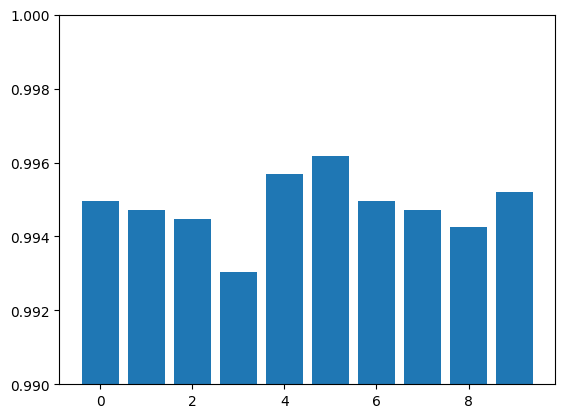

In [21]:

index = [i for i in range(10)]
  
plt.bar(index, acc)
print(np.mean(acc), np.max(acc), np.min(acc))
plt.ylim(0.99,1.0)

In [22]:

def get_labels_logits_and_preds(models):

    with torch.no_grad():
        logits = [[] for _ in range(10)]
        labels = []

        for images, labs in test_loader:

            images = images.to(device)
            labels.extend(labs)
            
            for i in range(10):
                logits[i].extend(models[i](images).cpu())


    return labels, logits

labels, logits = get_labels_logits_and_preds(models)

In [23]:
preds = [[] for _ in range(len(labels)) ]

for index in range(len(labels)):
    preds[index] = [np.argmax(logits[m][index].cpu().numpy()) for m in range(10)]

In [24]:
print(preds[4000])

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


In [25]:
def get_class_from_sum_of_logits(logits):

    sum_logits = []

    for i in range(len(logits[0])):

        log = logits[0][i]
        for m in range(1, 10):
            log = np.add(log, logits[m][i])
        sum_logits.append(np.argmax(log))
    return(sum_logits)
    
class_logits = get_class_from_sum_of_logits(logits)    

In [26]:
print(class_logits[0])

tensor(0)


In [28]:
import collections 

def get_stats(labels, class_preds, class_logits):

    all_correct = 0
    all_incorrect = 0
    maj_vote = 0
    maj_wrong = 0
    tie = 0
    count = 0

    for k in range(len(labels)):

        counter = collections.Counter(class_preds[k])
        if len(counter) == 1:
            if counter.most_common(1)[0][0] == labels[k]:
                all_correct += 1
            else:
                all_incorrect += 1
        else:
            aux = counter.most_common(2)
            if aux[0][1] > aux[1][1] and aux[0][0] == labels[k]:
                maj_vote += 1
            if aux[0][1] > aux[1][1] and aux[0][0] != labels[k]:
                maj_wrong += 1
            elif aux[0][1] == aux[1][1]:
                tie += 1

        count += 1 
        
    return [count, all_correct, all_incorrect, maj_vote, tie, maj_wrong]
    
    
res = get_stats(labels, preds, class_logits)
print('total: ', res[0])
print('All correct: ', res[1])
print('All incorrect: ', res[2])
print('Majority correct: ', res[3])
print('Tie Vote: ', res[4])
print('Majority Wrong: ', res[5])
print('Percentage right: ', (res[1]+res[3])/res[0])

total:  4170
All correct:  4113
All incorrect:  4
Majority correct:  42
Tie Vote:  2
Majority Wrong:  9
Percentage right:  0.9964028776978417
